# DSLab Homework 1 - Data Science with CO2

## Hand-in Instructions

- __Due: 23.03.2021 23h59 CET__
- `git push` your final verion to the master branch of your group's Renku repository before the due
- check if `Dockerfile`, `environment.yml` and `requirements.txt` are properly written
- add necessary comments and discussion to make your codes readable

## Carbosense

The project Carbosense establishes a uniquely dense CO2 sensor network across Switzerland to provide near-real time information on man-made emissions and CO2 uptake by the biosphere. The main goal of the project is to improve the understanding of the small-scale CO2 fluxes in Switzerland and concurrently to contribute to a better top-down quantification of the Swiss CO2 emissions. The Carbosense network has a spatial focus on the City of Zurich where more than 50 sensors are deployed. Network operations started in July 2017.

<img src="http://carbosense.wdfiles.com/local--files/main:project/CarboSense_MAP_20191113_LowRes.jpg" width="500">

<img src="http://carbosense.wdfiles.com/local--files/main:sensors/LP8_ZLMT_3.JPG" width="156">  <img src="http://carbosense.wdfiles.com/local--files/main:sensors/LP8_sensor_SMALL.jpg" width="300">

## Description of the homework

In this homework, we will curate a set of **CO2 measurements**, measured from cheap but inaccurate sensors, that have been deployed in the city of Zurich from the Carbosense project. The goal of the exercise is twofold: 

1. Learn how to deal with real world sensor timeseries data, and organize them efficiently using python dataframes.

2. Apply data science tools to model the measurements, and use the learned model to process them (e.g., detect drifts in the sensor measurements). 

The sensor network consists of 46 sites, located in different parts of the city. Each site contains three different sensors measuring (a) **CO2 concentration**, (b) **temperature**, and (c) **humidity**. Beside these measurements, we have the following additional information that can be used to process the measurements: 

1. The **altitude** at which the CO2 sensor is located, and the GPS coordinates (latitude, longitude).

2. A clustering of the city of Zurich in 17 different city **zones** and the zone in which the sensor belongs to. Some characteristic zones are industrial area, residential area, forest, glacier, lake, etc.

## Prior knowledge

The average value of the CO2 in a city is approximately 400 ppm. However, the exact measurement in each site depends on parameters such as the temperature, the humidity, the altitude, and the level of traffic around the site. For example, sensors positioned in high altitude (mountains, forests), are expected to have a much lower and uniform level of CO2 than sensors that are positioned in a business area with much higher traffic activity. Moreover, we know that there is a strong dependence of the CO2 measurements, on temperature and humidity.

Given this knowledge, you are asked to define an algorithm that curates the data, by detecting and removing potential drifts. **The algorithm should be based on the fact that sensors in similar conditions are expected to have similar measurements.** 

## To start with

The following csv files in the `../data/carbosense-raw/` folder will be needed: 

1. `CO2_sensor_measurements.csv`
    
   __Description__: It containts the CO2 measurements `CO2`, the name of the site `LocationName`, a unique sensor identifier `SensorUnit_ID`, and the time instance in which the measurement was taken `timestamp`.
    
2. `temperature_humidity.csv`

   __Description__: It contains the temperature and the humidity measurements for each sensor identifier, at each timestamp `Timestamp`. For each `SensorUnit_ID`, the temperature and the humidity can be found in the corresponding columns of the dataframe `{SensorUnit_ID}.temperature`, `{SensorUnit_ID}.humidity`.
    
3. `sensor_metadata.csv`

   __Description__: It contains the name of the site `LocationName`, the zone index `zone`, the altitude in meters `altitude`, the longitude `lon`, and the latitude `lat`. 

Import the following python packages:

In [398]:
import pandas as pd
import numpy as np
import sklearn
import plotly.express as px
import plotly.graph_objects as go
import os
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import scipy.stats
import statsmodels.api as sm
from causalimpact import CausalImpact

In [2]:
pd.options.mode.chained_assignment = None

## PART I: Handling time series with pandas (10 points)

### a) **8/10**

Merge the `CO2_sensor_measurements.csv`, `temperature_humidity.csv`, and `sensors_metadata.csv`, into a single dataframe. 

* The merged dataframe contains:
    - index: the time instance `timestamp` of the measurements
    - columns: the location of the site `LocationName`, the sensor ID `SensorUnit_ID`, the CO2 measurement `CO2`, the `temperature`, the `humidity`, the `zone`, the `altitude`, the longitude `lon` and the latitude `lat`.

| timestamp | LocationName | SensorUnit_ID | CO2 | temperature | humidity | zone | altitude | lon | lat |
|:---------:|:------------:|:-------------:|:---:|:-----------:|:--------:|:----:|:--------:|:---:|:---:|
|    ...    |      ...     |      ...      | ... |     ...     |    ...   |  ... |    ...   | ... | ... |



* For each measurement (CO2, humidity, temperature), __take the average over an interval of 30 min__. 

* If there are missing measurements, __interpolate them linearly__ from measurements that are close by in time.

__Hints__: The following methods could be useful

1. ```python 
pandas.DataFrame.resample()
``` 
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.resample.html
    
2. ```python
pandas.DataFrame.interpolate()
```
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.interpolate.html
    
3. ```python
pandas.DataFrame.mean()
```
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.mean.html
    
4. ```python
pandas.DataFrame.append()
```
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.append.html

In [3]:
!git lfs pull

In [4]:
co2_measurements = pd.read_csv("../data/carbosense-raw/CO2_sensor_measurements.csv",
                                sep="\t",
                                parse_dates=['timestamp'])
# rename for consistency of column names accross the dataframes
co2_measurements = co2_measurements.rename({'SensorUnit_ID':'sensor'}, axis=1)

In [5]:
co2_measurements.head()

timestamp LocationName  sensor         CO2
0 2017-10-01 00:05:00         ZGHD    1014  593.321562
1 2017-10-01 00:15:00         ZGHD    1014  595.846258
2 2017-10-01 00:25:00         ZGHD    1014  595.845353
3 2017-10-01 00:45:00         ZGHD    1014  599.039129
4 2017-10-01 00:55:00         ZGHD    1014  594.996629

In [6]:
co2_measurements[co2_measurements.LocationName == "ZHRO"]

timestamp LocationName  sensor         CO2
100100 2017-10-19 13:44:00         ZHRO    1117  435.517352
100101 2017-10-19 13:54:00         ZHRO    1117  431.920620
100102 2017-10-19 14:04:00         ZHRO    1117  433.222353
100103 2017-10-19 14:14:00         ZHRO    1117  427.284986
100104 2017-10-19 14:24:00         ZHRO    1117  431.055325
...                    ...          ...     ...         ...
101686 2017-10-31 23:04:00         ZHRO    1117  487.892983
101687 2017-10-31 23:24:00         ZHRO    1117  486.393620
101688 2017-10-31 23:34:00         ZHRO    1117  494.001575
101689 2017-10-31 23:44:00         ZHRO    1117  484.290109
101690 2017-10-31 23:54:00         ZHRO    1117  482.339393

[1591 rows x 4 columns]

In [7]:
co2_measurements.isnull().any(None) # verify null values

False

In [8]:
co2_measurements['sensor'] = co2_measurements['sensor'].astype(int)

In [9]:
# function to resample the C02 measurements dataframe
def co2_measurements_resample(df):
    res = df['CO2'].resample('30min').mean().to_frame()
    # Some periods of 30min have 0 datapoints, therefore we need to interpolate
    res = res.interpolate('linear', axis=0)
    # save the location name for each sensor
    res['LocationName'] = df['LocationName'].values[0]
    return res

co2_measurements = co2_measurements.set_index('timestamp') \
                                   .groupby('sensor') \
                                   .apply(co2_measurements_resample)

In [10]:
co2_measurements.groupby("LocationName").count()

CO2
LocationName      
AJGR          1488
BSCR          1488
BUDF          1488
KBRL          1488
KTGM          1488
RCTZ          1488
SMHK          1488
SZGL          1488
ULGW          1488
UTLI          1488
WMOO          1488
WRTW          1488
WSUM          1488
ZALL          1488
ZAML          1488
ZAZG          1488
ZBLG          1488
ZBRC          1488
ZDLT          1488
ZECB          1488
ZFBL          1488
ZFHB          1488
ZFRK          1488
ZGHD          1488
ZHBG          1488
ZHBR          1488
ZHRG          1488
ZHRO           597
ZHRZ          1488
ZLDW          1488
ZLMT          1488
ZNEU          1488
ZORL          1488
ZPFW           598
ZPRD          1488
ZRDH          1488
ZSBN          1488
ZSCH          1488
ZSEF          1488
ZSTA          1488
ZSTL          1488
ZSZW          1488
ZTBN          1488
ZUBG          1488
ZUE           1488
ZWCH          1488

In [11]:
co2_measurements.isnull().any(None)

False

In [12]:
temp_humidity = pd.read_csv("../data/carbosense-raw/temperature_humidity.csv",
                            sep="\t",
                            parse_dates=['Timestamp'])
# rename for consistency of column names accross the dataframes
temp_humidity = temp_humidity.rename({'Timestamp':'timestamp'}, axis=1)

In [13]:
temp_humidity.head()

timestamp  1014.temperature  1014.humidity  1015.temperature  \
0 2017-10-01 00:00:00             11.39      92.262787             10.55   
1 2017-10-01 00:10:00             11.39      92.579407             10.48   
2 2017-10-01 00:20:00             11.41      92.480225             10.51   
3 2017-10-01 00:30:00             11.35      91.902298             10.55   
4 2017-10-01 00:40:00             11.30      91.639084             10.59   

   1015.humidity  1016.temperature  1016.humidity  1017.temperature  \
0      91.949982             11.02      92.613739             11.05   
1      92.079681             11.04      93.063873             11.05   
2      92.583221             11.06      93.201202             11.02   
3      92.714828             11.02      92.932266             10.96   
4      92.764420             10.99      92.598480             10.95   

   1017.humidity  1018.temperature  ...  1291.temperature  1291.humidity  \
0      89.811844             11.38  ...             10.13      96.828979   
1      90.042633             11.38  ...             10.12      97.322983   
2      89.888138             11.35  ...             10.14      97.780746   
3      89.790863             11.31  ...             10.13      97.904724   
4      89.821381             11.27  ...             10.13      97.931427   

   1292.temperature  1292.humidity  1297.temperature  1297.humidity  \
0             10.50      95.858139             10.70      94.524902   
1             10.45      95.903915             10.53      94.395203   
2             10.43      95.343155             10.45      94.620270   
3             10.43      95.322174             10.42      94.973129   
4             10.48      96.451324             10.46      95.282120   

   1298.temperature  1298.humidity  1299.temperature  1299.humidity  
0             11.35      90.288681             11.44      90.118927  
1             11.35      90.422195             11.46      90.073151  
2             11.33      91.023010             11.41      89.466614  
3             11.32      91.019196             11.39      89.249176  
4             11.28      90.443176             11.31      88.871521  

[5 rows x 93 columns]

In [14]:
# Melt the dataframe into long format keeping only the timestamp
temp_humidity = pd.melt(temp_humidity, id_vars='timestamp', var_name='sensor.temp_humidity', value_name='measurement')
# split the Var column to get the sensor ID and the column name in seperate columns
temp_humidity[['sensor','temp_humidity']] = temp_humidity['sensor.temp_humidity'].str.split('.', expand=True)
# Finally pivot the dataframe to get it in a desired format
temp_humidity = temp_humidity.pivot(index=['timestamp','sensor'], columns='temp_humidity', values='measurement').reset_index()

In [15]:
temp_humidity

temp_humidity           timestamp sensor   humidity  temperature
0             2017-10-01 00:00:00   1014  92.262787        11.39
1             2017-10-01 00:00:00   1015  91.949982        10.55
2             2017-10-01 00:00:00   1016  92.613739        11.02
3             2017-10-01 00:00:00   1017  89.811844        11.05
4             2017-10-01 00:00:00   1018  91.427368        11.38
...                           ...    ...        ...          ...
205339        2017-10-31 23:50:00   1291  94.849152         1.96
205340        2017-10-31 23:50:00   1292  96.170944        -0.54
205341        2017-10-31 23:50:00   1297  94.997925         0.05
205342        2017-10-31 23:50:00   1298  83.046478         2.82
205343        2017-10-31 23:50:00   1299  82.041306         3.22

[205344 rows x 4 columns]

In [16]:
temp_humidity['sensor'] = temp_humidity['sensor'].astype(int)

In [17]:
temp_humidity.isnull().any(None)

True

In [18]:
# resample the temperature humidity dataframe every 30 min
temp_humidity = temp_humidity.set_index('timestamp') \
                             .groupby('sensor') \
                             .apply(lambda df: df[['temperature', 'humidity']]
                                               .interpolate('linear', axis=0) \
                                               .resample('30min').mean())

In [19]:
temp_humidity.isnull().any(None)

False

In [20]:
temp_humidity

temp_humidity               temperature   humidity
sensor timestamp                                  
1014   2017-10-01 00:00:00    11.396667  92.440806
       2017-10-01 00:30:00    11.303333  91.625097
       2017-10-01 01:00:00    11.240000  91.096761
       2017-10-01 01:30:00    11.260000  91.275734
       2017-10-01 02:00:00    11.285000  91.003937
...                                 ...        ...
1299   2017-10-31 21:30:00     3.923333  78.965388
       2017-10-31 22:00:00     3.766667  79.702896
       2017-10-31 22:30:00     3.493333  80.769740
       2017-10-31 23:00:00     3.373333  81.676366
       2017-10-31 23:30:00     3.286667  81.910970

[68448 rows x 2 columns]

In [21]:
metadata = pd.read_csv("../data/carbosense-raw/sensors_metadata.csv", sep="\t")

In [22]:
metadata.head()

LocationName  zone  altitude       lat       lon
0         AJGR     2     627.8  47.33321  8.480300
1         BSCR     2     462.3  47.35581  8.430070
2         BUDF    10     490.2  47.36270  8.433110
3         KBRL     7     510.5  47.32582  8.537550
4         KTGM     2     530.3  47.32334  8.596422

In [23]:
# merge all three dataframes together
temp_humidity = temp_humidity.reset_index()
co2_measurements = co2_measurements.reset_index()
final_df = pd.merge(temp_humidity, co2_measurements, how='inner', right_on=['sensor','timestamp'], left_on=['sensor','timestamp'])
final_df = pd.merge(final_df, metadata, left_on='LocationName', right_on='LocationName', validate='m:1')

In [24]:
final_df.isnull().any(None)

False

In [25]:
final_df = final_df.set_index('timestamp')

### b) **2/10** 

Export the curated and ready to use timeseries to a csv file, and properly push the merged csv to Git LFS.

In [26]:
os.chdir('..')

In [27]:
!git lfs track -l 

Listing tracked patterns
    data/carbosense-raw/temperature_humidity.csv (.gitattributes)
    data/carbosense-raw/CO2_sensor_measurements.csv (.gitattributes)
    data/carbosense-raw/final_df.csv (.gitattributes)
Listing excluded patterns


In [28]:
save_path = 'data/carbosense-raw/final_df.csv'

In [29]:
!git lfs track data/carbosense-raw/final_df.csv

"data/carbosense-raw/final_df.csv" already supported


In [30]:
!git lfs track -l 

Listing tracked patterns
    data/carbosense-raw/temperature_humidity.csv (.gitattributes)
    data/carbosense-raw/CO2_sensor_measurements.csv (.gitattributes)
    data/carbosense-raw/final_df.csv (.gitattributes)
Listing excluded patterns


In [31]:
final_df.to_csv(save_path, sep='\t')

In [32]:
# !git add  data/carbosense-raw/final_df.csv

In [33]:
# !git commit -m "df csv file"

In [34]:
# !git push

In [35]:
os.chdir('notebooks')

## PART II: Data visualization (15 points)

### a) **5/15** 
Group the sites based on their altitude, by performing K-means clustering. 
- Find the optimal number of clusters using the [Elbow method](https://en.wikipedia.org/wiki/Elbow_method_(clustering)). 
- Wite out the formula of metric you use for Elbow curve. 
- Perform clustering with the optimal number of clusters and add an additional column `altitude_cluster` to the dataframe of the previous question indicating the altitude cluster index. 
- Report your findings.

__Note__: [Yellowbrick](http://www.scikit-yb.org/) is a very nice Machine Learning Visualization extension to scikit-learn, which might be useful to you. 

In [36]:
metadata.head()

LocationName  zone  altitude       lat       lon
0         AJGR     2     627.8  47.33321  8.480300
1         BSCR     2     462.3  47.35581  8.430070
2         BUDF    10     490.2  47.36270  8.433110
3         KBRL     7     510.5  47.32582  8.537550
4         KTGM     2     530.3  47.32334  8.596422

In [37]:
site_data = metadata[['LocationName', 'altitude', 'lat', 'lon']]

In [38]:
# extracting altitude values of the sites 
X = site_data.altitude.values.reshape(-1,1)

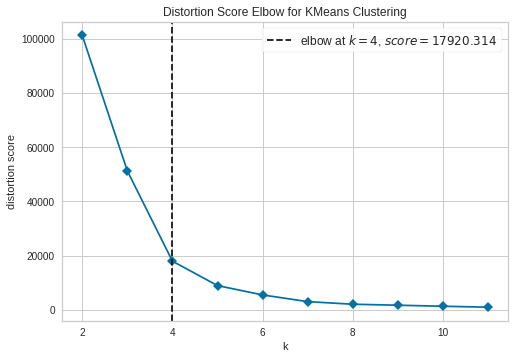

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [39]:
# Here we use the Elbow method to choose the optimal number of clusters
# We use KElbowVisualizer from Yelloybrick library to fit the model with different K values and choose the most optimal
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,12), timings = False, metric="distortion")
visualizer.fit(X)
visualizer.show()

In [40]:
# From the visualization in the previous cell, the optimal k by the elbow method is 4
optimal_k = visualizer.elbow_value_

### Metric used in the Elbow curve: mean Distortion 

We use here the mean distortion metric or the within-cluster sum of squares  i.e the mean of the square distances of each points from the center of the cluster assigned to it.

mean  distortion $= \frac{1}{N} * \sum_{k=1}^{K} \sum_{x\in {S_k}} (x- \mu_k)^{2}
$

where $\mu_k$ denotes the mean of the altitudes in the cluster k

In [41]:
# We fit the model with the optimal number of clusters
model = KMeans(n_clusters=optimal_k)
model.fit(X)

KMeans(n_clusters=4)

In [42]:
# we add the assigned cluster index to the dataframe
assigned_clusters = model.labels_
site_data['altitude_cluster'] = assigned_clusters

In [43]:
site_data.head()

LocationName  altitude       lat       lon  altitude_cluster
0         AJGR     627.8  47.33321  8.480300                 1
1         BSCR     462.3  47.35581  8.430070                 0
2         BUDF     490.2  47.36270  8.433110                 0
3         KBRL     510.5  47.32582  8.537550                 0
4         KTGM     530.3  47.32334  8.596422                 0

In [44]:
# We add the altitude_cluster column to the dataframe 
final_df = pd.merge(final_df.reset_index(), site_data[["LocationName", "altitude_cluster"]], on="LocationName").set_index("timestamp")

In [45]:
final_df

sensor  temperature   humidity         CO2 LocationName  \
timestamp                                                                      
2017-10-01 00:00:00    1014    11.396667  92.440806  595.004391         ZGHD   
2017-10-01 00:30:00    1014    11.303333  91.625097  597.017879         ZGHD   
2017-10-01 01:00:00    1014    11.240000  91.096761  596.487010         ZGHD   
2017-10-01 01:30:00    1014    11.260000  91.275734  598.787639         ZGHD   
2017-10-01 02:00:00    1014    11.285000  91.003937  595.366394         ZGHD   
...                     ...          ...        ...         ...          ...   
2017-10-31 21:30:00    1299     3.923333  78.965388  477.307329         ZLDW   
2017-10-31 22:00:00    1299     3.766667  79.702896  474.396830         ZLDW   
2017-10-31 22:30:00    1299     3.493333  80.769740  474.406102         ZLDW   
2017-10-31 23:00:00    1299     3.373333  81.676366  477.910252         ZLDW   
2017-10-31 23:30:00    1299     3.286667  81.910970  471.881151         ZLDW   

                     zone  altitude        lat       lon  altitude_cluster  
timestamp                                                                   
2017-10-01 00:00:00     2     413.5  47.370446  8.523256                 3  
2017-10-01 00:30:00     2     413.5  47.370446  8.523256                 3  
2017-10-01 01:00:00     2     413.5  47.370446  8.523256                 3  
2017-10-01 01:30:00     2     413.5  47.370446  8.523256                 3  
2017-10-01 02:00:00     2     413.5  47.370446  8.523256                 3  
...                   ...       ...        ...       ...               ...  
2017-10-31 21:30:00     5     405.9  47.348870  8.536290                 3  
2017-10-31 22:00:00     5     405.9  47.348870  8.536290                 3  
2017-10-31 22:30:00     5     405.9  47.348870  8.536290                 3  
2017-10-31 23:00:00     5     405.9  47.348870  8.536290                 3  
2017-10-31 23:30:00     5     405.9  47.348870  8.536290                 3  

[66667 rows x 10 columns]

## !!
<font style="color:red">Report your findings</font>

### b) **4/15** 

Use `plotly` (or other similar graphing libraries) to create an interactive plot of the monthly median CO2 measurement for each site with respect to the altitude. 

Add proper title and necessary hover information to each point, and give the same color to stations that belong to the same altitude cluster.

In [46]:
median_df = co2_measurements.groupby(by='LocationName').median()

In [47]:
median_df = median_df.drop(columns=["sensor"]).rename(columns={"CO2" : "CO2_median"})

In [48]:
median_df.head()

CO2_median
LocationName            
AJGR          334.785793
BSCR          474.502250
BUDF          422.793126
KBRL          410.100150
KTGM          444.395518

In [49]:
# We merge the two dataframes found
result = pd.merge(median_df, site_data, on='LocationName') 

# We change the altitude_cluster column type to str to have categorical colors in the plot
result["altitude_cluster"] = result["altitude_cluster"].astype(str)

In [50]:
result.head()

LocationName  CO2_median  altitude       lat       lon altitude_cluster
0         AJGR  334.785793     627.8  47.33321  8.480300                1
1         BSCR  474.502250     462.3  47.35581  8.430070                0
2         BUDF  422.793126     490.2  47.36270  8.433110                0
3         KBRL  410.100150     510.5  47.32582  8.537550                0
4         KTGM  444.395518     530.3  47.32334  8.596422                0

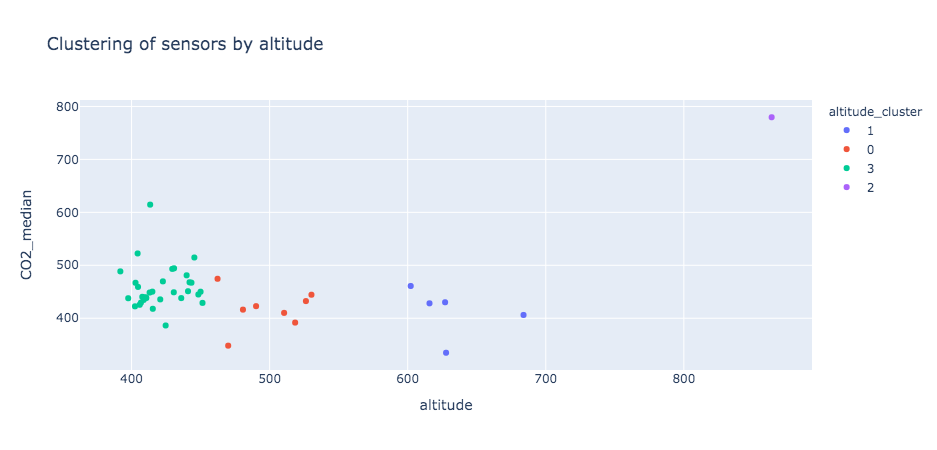

In [51]:
# we visualize the monthly median as a function of the altitude colored according to the clustering result
px.scatter(result, x='altitude', y='CO2_median', color='altitude_cluster', title="Clustering of sensors by altitude", hover_name="LocationName")

### c) **6/15**

Use `plotly` (or other similar graphing libraries) to plot an interactive time-varying density heatmap of the mean daily CO2 concentration for all the stations. Add proper title and necessary hover information.

__Hints:__ Check following pages for more instructions:
- [Animations](https://plotly.com/python/animations/)
- [Density Heatmaps](https://plotly.com/python/mapbox-density-heatmaps/)

In [52]:
# We compute the mean daily CO2 measurements for each site 
daily_co2_measurements = co2_measurements.groupby(by=["LocationName", co2_measurements['timestamp'].dt.day]).mean().drop(columns=["sensor"]).reset_index()

In [53]:
daily_co2_measurements.head()

LocationName  timestamp         CO2
0         AJGR          1  336.656408
1         AJGR          2  342.793705
2         AJGR          3  335.531220
3         AJGR          4  335.316507
4         AJGR          5  340.486617

In [54]:
site_data.head()

LocationName  altitude       lat       lon  altitude_cluster
0         AJGR     627.8  47.33321  8.480300                 1
1         BSCR     462.3  47.35581  8.430070                 0
2         BUDF     490.2  47.36270  8.433110                 0
3         KBRL     510.5  47.32582  8.537550                 0
4         KTGM     530.3  47.32334  8.596422                 0

In [55]:
final_df[final_df.LocationName == "ZHRO"]

sensor  temperature   humidity         CO2 LocationName  \
timestamp                                                                      
2017-10-19 13:30:00    1117    22.680000  42.270543  433.718986         ZHRO   
2017-10-19 14:00:00    1117    22.903333  44.397237  430.520888         ZHRO   
2017-10-19 14:30:00    1117    20.746667  48.766337  425.265832         ZHRO   
2017-10-19 15:00:00    1117    19.850000  47.809484  432.520878         ZHRO   
2017-10-19 15:30:00    1117    19.476667  48.056168  435.753967         ZHRO   
...                     ...          ...        ...         ...          ...   
2017-10-31 21:30:00    1117     3.180000  84.997696  486.615584         ZHRO   
2017-10-31 22:00:00    1117     2.870000  86.240651  487.632920         ZHRO   
2017-10-31 22:30:00    1117     2.680000  87.258858  491.697517         ZHRO   
2017-10-31 23:00:00    1117     2.516667  87.853633  487.143302         ZHRO   
2017-10-31 23:30:00    1117     2.316667  88.916662  486.877026         ZHRO   

                     zone  altitude       lat      lon  altitude_cluster  
timestamp                                                                 
2017-10-19 13:30:00     2     397.6  47.39394  8.48667                 3  
2017-10-19 14:00:00     2     397.6  47.39394  8.48667                 3  
2017-10-19 14:30:00     2     397.6  47.39394  8.48667                 3  
2017-10-19 15:00:00     2     397.6  47.39394  8.48667                 3  
2017-10-19 15:30:00     2     397.6  47.39394  8.48667                 3  
...                   ...       ...       ...      ...               ...  
2017-10-31 21:30:00     2     397.6  47.39394  8.48667                 3  
2017-10-31 22:00:00     2     397.6  47.39394  8.48667                 3  
2017-10-31 22:30:00     2     397.6  47.39394  8.48667                 3  
2017-10-31 23:00:00     2     397.6  47.39394  8.48667                 3  
2017-10-31 23:30:00     2     397.6  47.39394  8.48667                 3  

[597 rows x 10 columns]

In [56]:
# We merge the two dataframes 
daily_co2_measurements = pd.merge(daily_co2_measurements, site_data, on=["LocationName"])

In [57]:
daily_co2_measurements.head()

LocationName  timestamp         CO2  altitude       lat     lon  \
0         AJGR          1  336.656408     627.8  47.33321  8.4803   
1         AJGR          2  342.793705     627.8  47.33321  8.4803   
2         AJGR          3  335.531220     627.8  47.33321  8.4803   
3         AJGR          4  335.316507     627.8  47.33321  8.4803   
4         AJGR          5  340.486617     627.8  47.33321  8.4803   

   altitude_cluster  
0                 1  
1                 1  
2                 1  
3                 1  
4                 1

In [58]:
daily_co2_measurements = daily_co2_measurements.rename(columns={'timestamp' : 'day'})


In [59]:
# compute min and max CO2 mean 
min_CO2_mean = daily_co2_measurements.CO2.values.min()
max_CO2_mean = daily_co2_measurements.CO2.values.max()

In [60]:
daily_co2_measurements[daily_co2_measurements.LocationName == "ZHRO"]

LocationName  day         CO2  altitude       lat      lon  \
837         ZHRO   19  478.827507     397.6  47.39394  8.48667   
838         ZHRO   20  480.498404     397.6  47.39394  8.48667   
839         ZHRO   21  449.161076     397.6  47.39394  8.48667   
840         ZHRO   22  415.860085     397.6  47.39394  8.48667   
841         ZHRO   23  422.822681     397.6  47.39394  8.48667   
842         ZHRO   24  448.630152     397.6  47.39394  8.48667   
843         ZHRO   25  484.255093     397.6  47.39394  8.48667   
844         ZHRO   26  502.633532     397.6  47.39394  8.48667   
845         ZHRO   27  465.331350     397.6  47.39394  8.48667   
846         ZHRO   28  453.629619     397.6  47.39394  8.48667   
847         ZHRO   29  428.356598     397.6  47.39394  8.48667   
848         ZHRO   30  435.449369     397.6  47.39394  8.48667   
849         ZHRO   31  454.359963     397.6  47.39394  8.48667   

     altitude_cluster  
837                 3  
838                 3  
839                 3  
840                 3  
841                 3  
842                 3  
843                 3  
844                 3  
845                 3  
846                 3  
847                 3  
848                 3  
849                 3

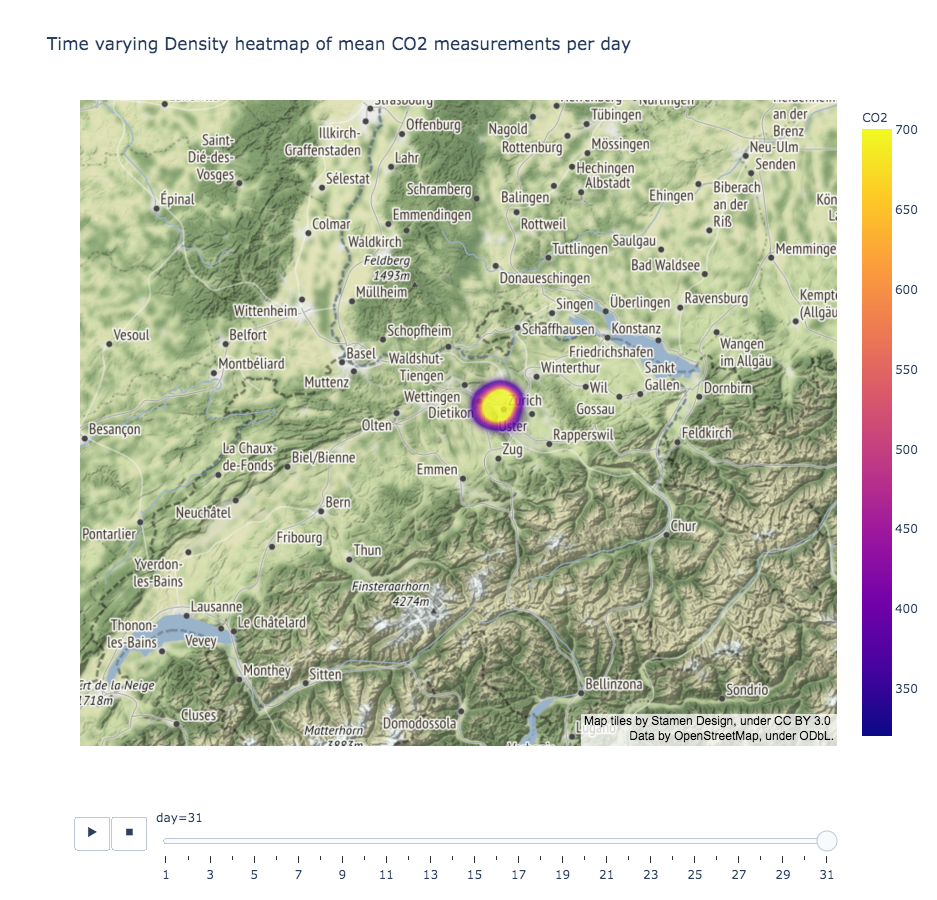

In [139]:
fig = px.density_mapbox(daily_co2_measurements, lat='lat', lon='lon', z='CO2', radius=20,
                        center=dict(lat=daily_co2_measurements.lat.mean(), lon=daily_co2_measurements.lon.mean()), zoom=11,
                        mapbox_style="stamen-terrain", animation_frame='day', animation_group='LocationName', 
                        hover_name='LocationName', title='Time varying Density heatmap of mean CO2 measurements per day',
                        range_color=[min_CO2_mean, 700], height=900, width=900, opacity=0.8)

fig.show()

**Remark:**

**Two sensors (ZHRO and ZPFW) do not appear in the density map above before the 19$^{th}$ day of the month. This is due to the fact that no measurements are present before this date in the dataset. (We didn't fill their missing measurements with 0 to avoid inconsistency).**

## PART III: Model fitting for data curation (35 points)

### a) **2/35**

The domain experts in charge of these sensors report that one of the CO2 sensors `ZSBN` is exhibiting a drift on Oct. 24. Verify the drift by visualizing the CO2 concentration of the drifting sensor and compare it with some other sensors from the network. 

In [62]:
# keep only C02 values after Oct 20 and for a few selected regions in order to compare
df_after_oct_20 = final_df[final_df.index.day >= 20]
df_comparison = df_after_oct_20[df_after_oct_20['LocationName'].isin(['ZSBN','ZLDW','SMHK','ZWCH'])]

In [63]:
df_comparison

sensor  temperature   humidity         CO2 LocationName  \
timestamp                                                                      
2017-10-20 00:00:00    1031     9.066667  90.476237  485.018536         ZSBN   
2017-10-20 00:30:00    1031     8.896667  91.278595  485.934438         ZSBN   
2017-10-20 01:00:00    1031     8.670000  91.745895  488.722457         ZSBN   
2017-10-20 01:30:00    1031     8.490000  92.423004  485.117310         ZSBN   
2017-10-20 02:00:00    1031     8.296667  92.759969  482.602432         ZSBN   
...                     ...          ...        ...         ...          ...   
2017-10-31 21:30:00    1299     3.923333  78.965388  477.307329         ZLDW   
2017-10-31 22:00:00    1299     3.766667  79.702896  474.396830         ZLDW   
2017-10-31 22:30:00    1299     3.493333  80.769740  474.406102         ZLDW   
2017-10-31 23:00:00    1299     3.373333  81.676366  477.910252         ZLDW   
2017-10-31 23:30:00    1299     3.286667  81.910970  471.881151         ZLDW   

                     zone  altitude        lat       lon  altitude_cluster  
timestamp                                                                   
2017-10-20 00:00:00     3     415.4  47.385835  8.477908                 3  
2017-10-20 00:30:00     3     415.4  47.385835  8.477908                 3  
2017-10-20 01:00:00     3     415.4  47.385835  8.477908                 3  
2017-10-20 01:30:00     3     415.4  47.385835  8.477908                 3  
2017-10-20 02:00:00     3     415.4  47.385835  8.477908                 3  
...                   ...       ...        ...       ...               ...  
2017-10-31 21:30:00     5     405.9  47.348870  8.536290                 3  
2017-10-31 22:00:00     5     405.9  47.348870  8.536290                 3  
2017-10-31 22:30:00     5     405.9  47.348870  8.536290                 3  
2017-10-31 23:00:00     5     405.9  47.348870  8.536290                 3  
2017-10-31 23:30:00     5     405.9  47.348870  8.536290                 3  

[2304 rows x 10 columns]

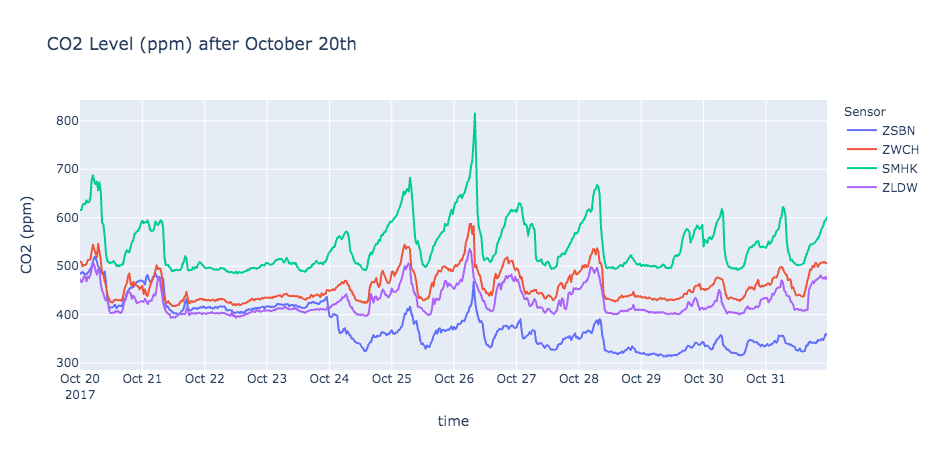

In [64]:
fig = px.line(df_comparison,
              y='CO2',
              color='LocationName',
              labels={
                  'timestamp':'time',
                  'CO2':'CO2 (ppm)',
                  'LocationName':'Sensor'
              }, 
              title='CO2 Level (ppm) after October 20th')

fig.update_xaxes(
    dtick=24*60*60*1000
)

fig.update_layout(
    hovermode='x unified'
)

fig.show()

**We see that the sensor measurements seem to be lower than they should. Indeed, assuming that the `ZSBN`, `ZWCH` and `ZLDW` sensors should yield close measurements to one another, we see that `ZSBN` is exhibiting a drift of about $-100\ ppm$ starting 24 Oct.**

### b) **8/35**

The domain experts ask you if you could reconstruct the CO2 concentration of the drifting sensor had the drift not happened. You decide to:
- Fit a linear regression model to the CO2 measurements of the site, by considering as features the covariates not affected by the malfunction (such as temperature and humidity)
- Create an interactive plot with `plotly` (or other similar graphing libraries):
    - the actual CO2 measurements
    - the values obtained by the prediction of the linear model for the entire month of October
    - the __confidence interval__ obtained from cross validation
- What do you observe? Report your findings.

__Note:__ Cross validation on time series is different from that on other kinds of datasets. The following diagram illustrates the series of training sets (in orange) and validation sets (in blue). For more on time series cross validation, there are a lot of interesting articles available online. scikit-learn provides a nice method [`sklearn.model_selection.TimeSeriesSplit`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html).

![ts_cv](https://player.slideplayer.com/86/14062041/slides/slide_28.jpg)

In [66]:
# Dataframe for regression, only ZSBN data is kept, with the unaffected covariates
reg_df = final_df.loc[final_df['LocationName'] == 'ZSBN', ['temperature', 'humidity', 'CO2']]
reg_df['time'] = reg_df.reset_index().index

In [67]:
# Function that performs rolling cross validation and returns the best model (According to MSE)
# and the used training set
def rolling_cross_validation(X, y):
    # split the dataset
    series_split = TimeSeriesSplit(n_splits=50)
    model = LinearRegression()
    min_mse = np.inf
    final_train_ind = None
    # iterate on the different train-test split in order to pick the best model
    for train_indices, test_indices in series_split.split(X):
        train_x, train_y = X[train_indices], y[train_indices]
        test_x, test_y = X[test_indices], y[test_indices]
        model.fit(train_x, train_y)
        mse = mean_squared_error(test_y, model.predict(test_x))
        if mse <= min_mse:
            min_mse = mse
            final_train_ind = train_indices
    return final_train_ind 

In [68]:
# only keep values before OCT 24 for training
X_train = reg_df.loc[reg_df.index.day < 24, ['temperature', 'humidity', 'time']].values
y_train = reg_df.loc[reg_df.index.day < 24, 'CO2'].values
X_pred = reg_df[['temperature', 'humidity', 'time']].values

In [69]:
X_train

array([[1.11466667e+01, 9.26080170e+01, 0.00000000e+00],
       [1.09150000e+01, 9.22208252e+01, 1.00000000e+00],
       [1.08600000e+01, 9.26620585e+01, 2.00000000e+00],
       ...,
       [7.98500000e+00, 9.16114273e+01, 1.10100000e+03],
       [8.00500000e+00, 9.18339513e+01, 1.10200000e+03],
       [8.04000000e+00, 9.21394450e+01, 1.10300000e+03]])

In [70]:
train_indices = rolling_cross_validation(X_train, y_train)
X_train = X_train[train_indices]
y_train = y_train[train_indices]

In [71]:
# We use StatsModels in order to compute the 95% CIs
ols = sm.OLS(y_train, sm.add_constant(X_train))
results = ols.fit()
predictions = results.get_prediction(sm.add_constant(X_pred))
conf_intervals =  predictions.conf_int()

In [72]:
reg_df['lower_ci'] = conf_intervals[:, 0]
reg_df['upper_ci'] = conf_intervals[:, 1]
reg_df['predicted'] = predictions.predicted_mean

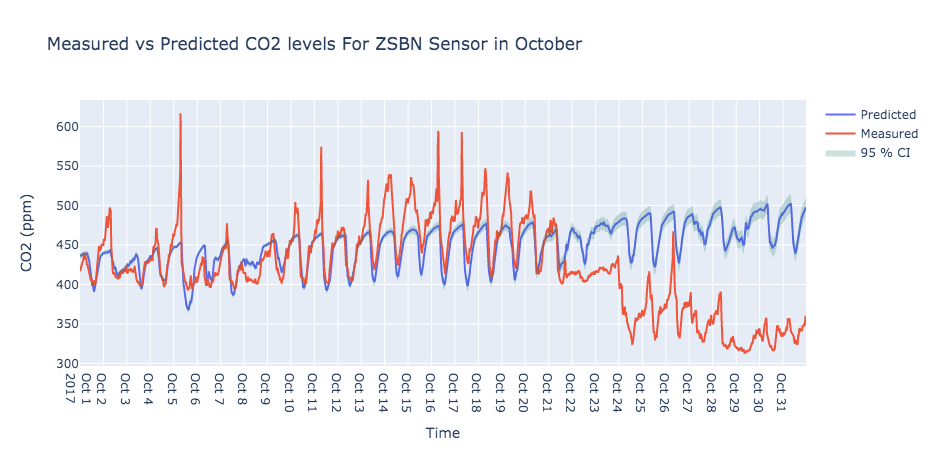

In [73]:
fig = go.Figure([go.Scatter(x=reg_df.index,
                            y=reg_df['predicted'],
                            mode='lines', name='Predicted'), 
                 go.Scatter(x=reg_df.index,
                            y=reg_df['CO2'],
                            mode='lines', name='Measured'),
                 go.Scatter(x=reg_df.index.append(reg_df.index[::-1]),
                            y=list(reg_df['upper_ci']) + list(reg_df['lower_ci'][::-1]),
                            fill='toself',
                            fillcolor='rgba(0,100,80,0.2)',
                            line=dict(color='rgba(255,255,255,0)'),
                            name='95 % CI')])

fig.update_xaxes(dtick=24*60*60*1000)
fig.update_layout(hovermode='x unified', title='Measured vs Predicted CO2 levels For ZSBN Sensor in October', xaxis_title="Time", yaxis_title="CO2 (ppm)")
fig.show()

**We observe that the predicted CO2 levels are significantly higher than the measured levels. We also see that out confidense interval is quite tight around the predicted values, which means that our model is quite confident in its prediction which enforces the doubts about the malfunction of the sensor.**

### c) **10/35**

In your next attempt to solve the problem, you decide to exploit the fact that the CO2 concentrations, as measured by the sensors __experiencing similar conditions__, are expected to be similar.

- Find the sensors sharing similar conditions with `ZSBN`. Explain your definition of "similar condition".
- Fit a linear regression model to the CO2 measurements of the site, by considering as features:
    - the information of provided by similar sensors
    - the covariates associated with the faulty sensors that were not affected by the malfunction (such as temperature and humidity).
- Create an interactive plot with `plotly` (or other similar graphing libraries):
    - the actual CO2 measurements
    - the values obtained by the prediction of the linear model for the entire month of October
    - the __confidence interval__ obtained from cross validation
- What do you observe? Report your findings.

## Similar Sensors

**We consider "similar conditions" as being in the same altitude cluster and in the same zone. 
Sensors in the same zone and similar altitude are expected to have same CO2 behavior. For example, sensors in the city center and on the same altitude experience the same conditions**

In [ ]:
# extracting the cluster of ZSBN sensor
zsbn_cluster = aver_conditions[aver_conditions.LocationName == "ZSBN"].altitude_cluster.iloc[0]

# extracting the cluster of ZSBN sensor
zsbn_zone= aver_conditions[aver_conditions.LocationName == "ZSBN"]["zone"].iloc[0]

In [343]:
#extracting similar sensors
similar = final_df[final_df.altitude_cluster== zsbn_cluster]
similar = similar[similar.zone == zsbn_zone]
similar = similar[similar.LocationName != "ZSBN"]

In [344]:
# extracting the location name of the sensors as a set
similar_sensors = set(similar.LocationName.unique())

In [345]:
similar_sensors

{'ZHRG', 'ZHRZ', 'ZUE'}

In [285]:
# Extract CO2 measurements of similar sensors
co2_similar_sensors= final_df[final_df.LocationName.isin(similar_sensors)][["LocationName", "CO2"]]
co2_similar_sensors = co2_similar_sensors.pivot(columns='LocationName', values='CO2')
co2_similar_sensors.head()

In [346]:
# Extract temperature and humidity of ZSBN sensor
features = final_df[final_df.LocationName == "ZSBN"][["temperature", "humidity"]]
features = pd.merge(features, co2_similar_sensors, left_index=True, right_index= True)
features.head()

temperature   humidity        ZHRG        ZHRZ  \
timestamp                                                             
2017-10-01 00:00:00    11.146667  92.608017  425.095878  473.752753   
2017-10-01 00:30:00    10.915000  92.220825  424.306724  475.523302   
2017-10-01 01:00:00    10.860000  92.662059  426.618723  478.572556   
2017-10-01 01:30:00    10.820000  92.934809  430.540983  479.827133   
2017-10-01 02:00:00    10.760000  93.407832  428.007043  482.656518   

                            ZUE  
timestamp                        
2017-10-01 00:00:00  426.441072  
2017-10-01 00:30:00  425.014187  
2017-10-01 01:00:00  423.912754  
2017-10-01 01:30:00  424.853283  
2017-10-01 02:00:00  422.021929

In [347]:
# Extract CO2 measurements of ZSBN sensor
co2_measure_zsbn = final_df[final_df.LocationName == "ZSBN"]["CO2"]

In [348]:
# We construct the feature and target vector to fit the model 
# i.e features and zsbn co2 measurements before 24th October
X_before_24 = features[features.index < "2017-10-24"]
y_before_24 = co2_measure_zsbn[co2_measure_zsbn.index < "2017-10-24"]

In [353]:
# compute cross validation to compute 
X_train = np.array(X_before_24)
y_train = np.array(y_before_24)
train_indices = rolling_cross_validation(X_train, y_train)
X_train = X_train[train_indices]
y_train = y_train[train_indices]

In [354]:
# We use StatsModels in order to compute the 95% CIs
ols = sm.OLS(y_train, sm.add_constant(X_train))
results = ols.fit()
predictions = results.get_prediction(sm.add_constant(np.array(features)))
conf_intervals =  predictions.conf_int()

In [355]:
result_df= features.copy()
result_df['lower_ci'] = conf_intervals[:, 0]
result_df['upper_ci'] = conf_intervals[:, 1]
result_df["predicted_CO2"] = predictions.predicted_mean
result_df["actual_CO2"]= co2_measure_zsbn

In [356]:
result_df.head()

temperature   humidity        ZHRG        ZHRZ  \
timestamp                                                             
2017-10-01 00:00:00    11.146667  92.608017  425.095878  473.752753   
2017-10-01 00:30:00    10.915000  92.220825  424.306724  475.523302   
2017-10-01 01:00:00    10.860000  92.662059  426.618723  478.572556   
2017-10-01 01:30:00    10.820000  92.934809  430.540983  479.827133   
2017-10-01 02:00:00    10.760000  93.407832  428.007043  482.656518   

                            ZUE    lower_ci    upper_ci  predicted_CO2  \
timestamp                                                                
2017-10-01 00:00:00  426.441072  424.904240  428.439064     426.671652   
2017-10-01 00:30:00  425.014187  424.853910  428.255575     426.554743   
2017-10-01 01:00:00  423.912754  426.886933  430.178780     428.532857   
2017-10-01 01:30:00  424.853283  428.984462  432.180138     430.582300   
2017-10-01 02:00:00  422.021929  428.895394  432.220684     430.558039   

                     actual_CO2  
timestamp                        
2017-10-01 00:00:00  418.493079  
2017-10-01 00:30:00  418.169200  
2017-10-01 01:00:00  421.749522  
2017-10-01 01:30:00  424.363039  
2017-10-01 02:00:00  423.172512

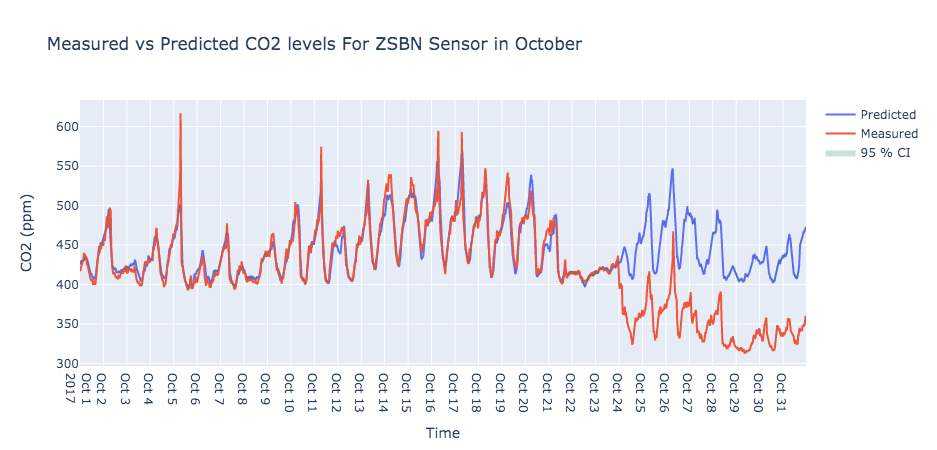

In [357]:
fig = go.Figure([go.Scatter(x=result_df.index,
                            y=result_df['predicted_CO2'],
                            mode='lines', name='Predicted'), 
                 go.Scatter(x=result_df.index,
                            y=result_df['actual_CO2'],
                            mode='lines', name='Measured'),
                 go.Scatter(x=result_df.index.append(result_df.index[::-1]),
                            y=list(result_df['upper_ci']) + list(result_df['lower_ci'][::-1]),
                            fill='toself',
                            fillcolor='rgba(0,100,80,0.2)',
                            line=dict(color='rgba(255,255,255,0)'),
                            name='95 % CI')])

fig.update_xaxes(dtick=24*60*60*1000)
fig.update_layout(hovermode='x unified', title='Measured vs Predicted CO2 levels For ZSBN Sensor in October', xaxis_title="Time", yaxis_title="CO2 (ppm)")
fig.show()

**We observe that the predicted CO2 measurements show same wiggling behavior as the measured ones. This aspect was not present when using only the covariates that are not affected by the malfunction.**

## !!
<font style="color:red">Report your findings</font>

### d) **10/35**

Now, instead of feeding the model with all features, you want to do something smarter by using linear regression with fewer features.

- Start with the same sensors and features as in question c)
- Leverage at least two different feature selection methods
- Create similar interactive plot as in question c)
- Describe the methods you choose and report your findings

## First Feature selection method: Univariate selection based on F-score

One way to select the most relevant features is by using Univariate selection. The method consists of computing the correlation between each feature and the target variable (Here, the CO2 measurement). We then keep the most k correlated features.
This approach detects only linear relationship between the covariate and the target.

In [378]:
# declare the feature selector, here we select the best 2 features
selector = SelectKBest(f_regression, k=2)
selector.fit(X_before_24, y_before_24)

# We retrieve the index of the best features
best_features = np.where(selector.get_support())[0]
best_features

array([2, 3])

In [385]:
# retrieve the relevant features
X_train = np.array(X_before_24)[:, best_features]
y_train = np.array(y_before_24)

In [388]:
train_indices = rolling_cross_validation(X_train, y_train)
X_train = X_train[train_indices]
y_train = y_train[train_indices]

In [390]:
X_pred= np.array(features)[:, best_features]

# We use StatsModels in order to compute the 95% CIs
ols = sm.OLS(y_train, sm.add_constant(X_train))
results = ols.fit()
predictions = results.get_prediction(sm.add_constant(X_pred))
conf_intervals =  predictions.conf_int()

In [393]:
result_df= features.copy()
# saving the predictions and the confidence interval boundaries in the dataframe
result_df['lower_ci'] = conf_intervals[:, 0]
result_df['upper_ci'] = conf_intervals[:, 1]
result_df["predicted_CO2"] = predictions.predicted_mean
result_df["actual_CO2"]= co2_measure_zsbn

In [397]:
result_df.head()

temperature   humidity        ZHRG        ZHRZ  \
timestamp                                                             
2017-10-01 00:00:00    11.146667  92.608017  425.095878  473.752753   
2017-10-01 00:30:00    10.915000  92.220825  424.306724  475.523302   
2017-10-01 01:00:00    10.860000  92.662059  426.618723  478.572556   
2017-10-01 01:30:00    10.820000  92.934809  430.540983  479.827133   
2017-10-01 02:00:00    10.760000  93.407832  428.007043  482.656518   

                            ZUE    lower_ci    upper_ci  predicted_CO2  \
timestamp                                                                
2017-10-01 00:00:00  426.441072  418.819889  420.721351     419.770620   
2017-10-01 00:30:00  425.014187  419.016065  420.932954     419.974509   
2017-10-01 01:00:00  423.912754  421.096631  422.963049     422.029840   
2017-10-01 01:30:00  424.853283  423.359930  425.149439     424.254684   
2017-10-01 02:00:00  422.021929  423.062262  424.916983     423.989622   

                     actual_CO2  
timestamp                        
2017-10-01 00:00:00  418.493079  
2017-10-01 00:30:00  418.169200  
2017-10-01 01:00:00  421.749522  
2017-10-01 01:30:00  424.363039  
2017-10-01 02:00:00  423.172512

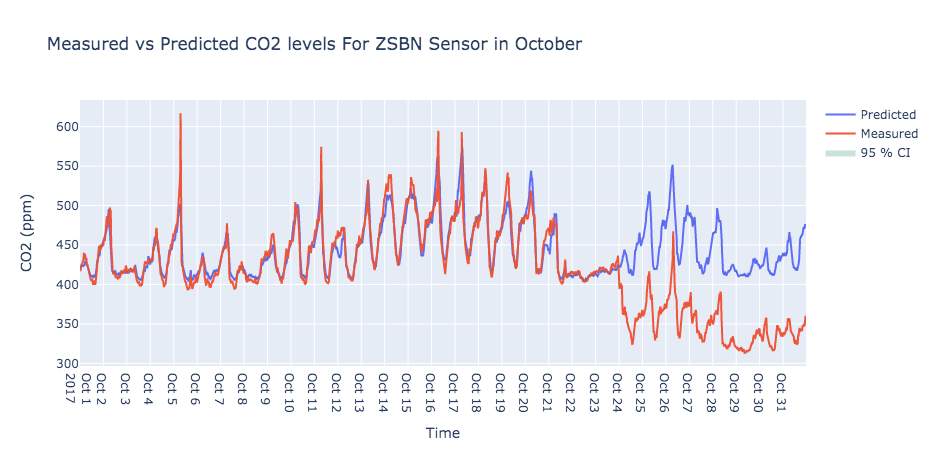

In [395]:
fig = go.Figure([go.Scatter(x=result_df.index,
                            y=result_df['predicted_CO2'],
                            mode='lines', name='Predicted'), 
                 go.Scatter(x=result_df.index,
                            y=result_df['actual_CO2'],
                            mode='lines', name='Measured'),
                 go.Scatter(x=result_df.index.append(result_df.index[::-1]),
                            y=list(result_df['upper_ci']) + list(result_df['lower_ci'][::-1]),
                            fill='toself',
                            fillcolor='rgba(0,100,80,0.2)',
                            line=dict(color='rgba(255,255,255,0)'),
                            name='95 % CI')])

fig.update_xaxes(dtick=24*60*60*1000)
fig.update_layout(hovermode='x unified', title='Measured vs Predicted CO2 levels For ZSBN Sensor in October', xaxis_title="Time", yaxis_title="CO2 (ppm)")
fig.show()

**There is no big difference with the previous plot**

## !!
<font style="color:red">Report your findings</font>

## Second Feature selection method: Recursive feature elimination

In [164]:
from sklearn.feature_selection import RFE

In [165]:
model= LinearRegression()

In [166]:
rfe = RFE(estimator=model, n_features_to_select=2, step=1)

In [176]:
rfe.fit(X_train, y_train)

RFE(estimator=LinearRegression(), n_features_to_select=2)

In [177]:
rfe.ranking_

array([1, 1, 3, 4, 5, 2])

In [172]:
ols = sm.OLS(y_train, sm.add_constant(X_train))

In [ ]:
from sklearn.s

In [174]:
r = ols.fit()

In [175]:
r.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.883
Model:                            OLS   Adj. R-squared:                  0.882
Method:                 Least Squares   F-statistic:                     1375.
Date:                Mon, 22 Mar 2021   Prob (F-statistic):               0.00
Time:                        18:49:58   Log-Likelihood:                -4370.0
No. Observations:                1104   AIC:                             8754.
Df Residuals:                    1097   BIC:                             8789.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        112.0602      6.614     16.943      0.000      99.083     125.037
x1             1.4432      0.161      8.991      0.000       1.128       1.758
x2             0.8217      0.061     13.569      0.000       0.703       0.940
x3             0.1840      0.012     14.917      0.000       0.160       0.208
x4             0.0191      0.006      3.445      0.001       0.008       0.030
x5             0.0142      0.005      2.702      0.007       0.004       0.024
x6             0.2863      0.012     24.860      0.000       0.264       0.309
==============================================================================
Omnibus:                      320.964   Durbin-Watson:                   0.756
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            12468.117
Skew:                           0.603   Prob(JB):                         0.00
Kurtosis:                      19.419   Cond. No.                     1.81e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.81e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [124]:
# We retrieve the index of the best features
best_features = np.where(selector.get_support())[0]
best_features

array([2, 5])

## !!
<font style="color:red">Report your findings</font>

### e) **5/35**

Eventually, you'd like to try something new - __Bayesian Structural Time Series Modelling__ - to reconstruct counterfactual values, that is, what the CO2 measurements of the faulty sensor should have been, had the malfunction not happened on October 24. You will use:
- the information of provided by similar sensors - the ones you identified in question c)
- the covariates associated with the faulty sensors that were not affected by the malfunction (such as temperature and humidity).

To answer this question, you can choose between a Python port of the CausalImpact package (such as https://github.com/dafiti/causalimpact) or the original R version (https://google.github.io/CausalImpact/CausalImpact.html) that you can run in your notebook via an R kernel (https://github.com/IRkernel/IRkernel).

Before you start, watch first the [presentation](https://www.youtube.com/watch?v=GTgZfCltMm8) given by Kay Brodersen (one of the creators of the causal impact implementation in R), and this introductory [ipython notebook](http://nbviewer.jupyter.org/github/dafiti/causalimpact/blob/master/examples/getting_started.ipynb) with examples of how to use the python package.

- Report your findings:
    - Is the counterfactual reconstruction of CO2 measurements significantly different from the observed measurements?
    - Can you try to explain the results?

In [126]:
d = final_df[final_df.LocationName == 'ZSBN'][['CO2','temperature','humidity']]
d.head()

CO2  temperature   humidity
timestamp                                              
2017-10-01 00:00:00  418.493079    11.146667  92.608017
2017-10-01 00:30:00  418.169200    10.915000  92.220825
2017-10-01 01:00:00  421.749522    10.860000  92.662059
2017-10-01 01:30:00  424.363039    10.820000  92.934809
2017-10-01 02:00:00  423.172512    10.760000  93.407832

In [127]:
similar_df = final_df[final_df.LocationName.isin(similar_sensors)][['CO2','LocationName','temperature','humidity']]
similar_df.head()

CO2 LocationName  temperature   humidity
timestamp                                                           
2017-10-01 00:00:00  445.905382         ZFBL    10.376667  92.005295
2017-10-01 00:30:00  448.274248         ZFBL    10.353333  92.896027
2017-10-01 01:00:00  451.841394         ZFBL    10.373333  93.082947
2017-10-01 01:30:00  449.712983         ZFBL    10.320000  93.176407
2017-10-01 02:00:00  455.367638         ZFBL    10.246667  93.190394

In [128]:
cols = list(d.columns)
[cols.append(x) for x in similar_df.LocationName.unique()]
cols

['CO2', 'temperature', 'humidity', 'ZFBL', 'SMHK', 'ZALL', 'SZGL']

In [129]:
observations = d.join(similar_df.pivot(columns='LocationName', values='CO2'))[cols]
observations.head()

CO2  temperature   humidity        ZFBL  \
timestamp                                                             
2017-10-01 00:00:00  418.493079    11.146667  92.608017  445.905382   
2017-10-01 00:30:00  418.169200    10.915000  92.220825  448.274248   
2017-10-01 01:00:00  421.749522    10.860000  92.662059  451.841394   
2017-10-01 01:30:00  424.363039    10.820000  92.934809  449.712983   
2017-10-01 02:00:00  423.172512    10.760000  93.407832  455.367638   

                           SMHK        ZALL        SZGL  
timestamp                                                
2017-10-01 00:00:00  484.178873  447.510132  464.380434  
2017-10-01 00:30:00  486.809488  449.106198  471.547286  
2017-10-01 01:00:00  486.607532  455.660947  472.346040  
2017-10-01 01:30:00  490.532202  456.727708  473.017374  
2017-10-01 02:00:00  493.743358  462.581609  478.258263

In [130]:
ci = CausalImpact(observations,
                  ['2017-10-01 00:00:00', '2017-10-23 23:30:00'],
                  ['2017-10-24 00:00:00', '2017-10-31 23:30:00'])

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency 30T will be used.

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency 30T will be used.



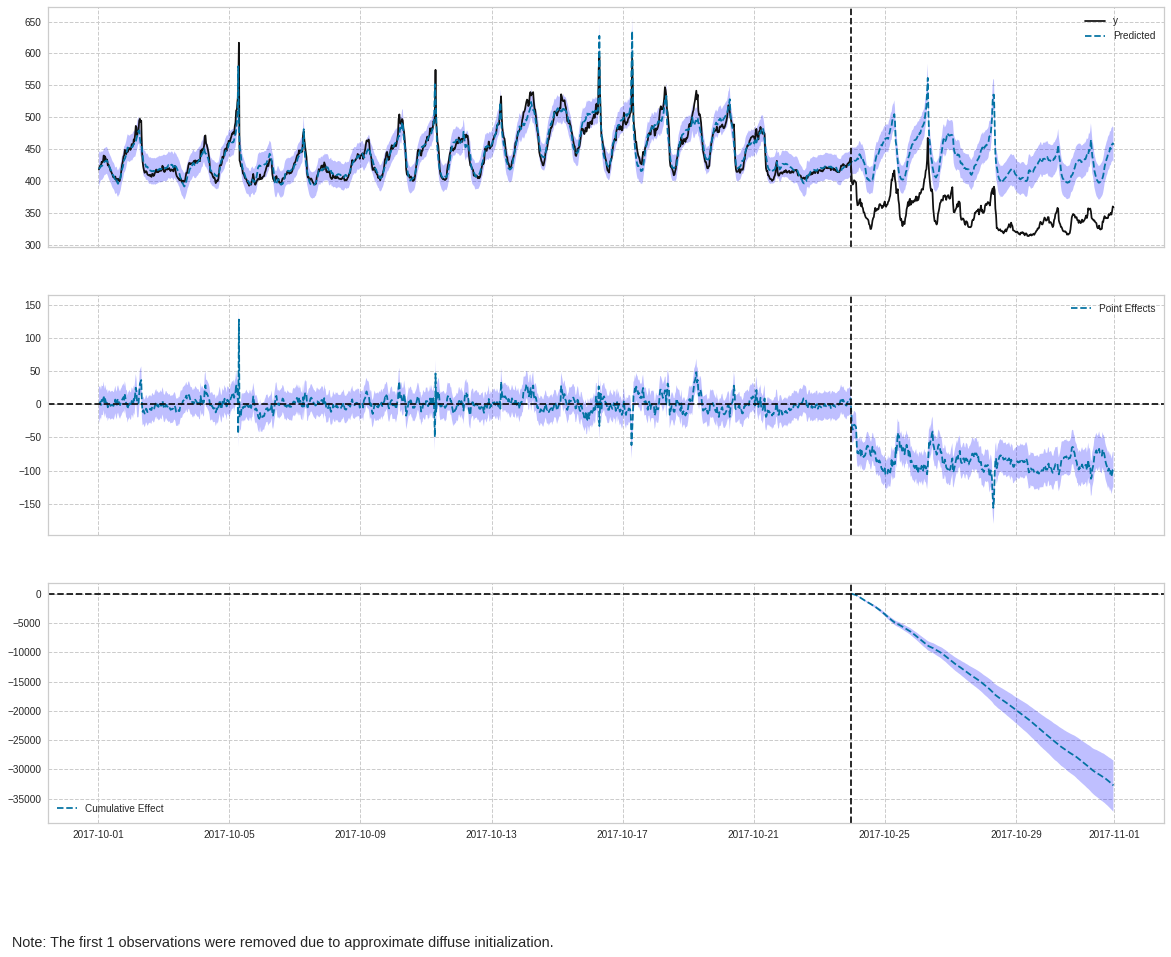

In [131]:
ci.plot(figsize=(20, 15))

In [132]:
report = ci.summary(output='report').replace('an\nintervention', 'a\nfailure').replace('intervention', 'failure')
print(report)

Analysis report {CausalImpact}


During the post-failure period, the response variable had
an average value of approx. 349.47. By contrast, in the absence of a
failure, we would have expected an average response of 434.74.
The 95% interval of this counterfactual prediction is [423.7, 446.44].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the failure had on the
response variable. This effect is -85.27 with a 95% interval of
[-96.97, -74.22]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-failure
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 134197.67.
By contrast, had the failure not taken place, we would have expected
a sum of 166940.75. The 95% interval of this prediction is [162699.59, 171432.37].


The above results are given in terms of absolute numbers. In relative
terms, the response variable showe

We see that the counterfactual reconstruction of CO2 measurements is different from the observed measurements according to the first graph. Indeed, we observe from the second graph a causal effect of $-80\ ppm$ which confirms the claim about the malfunction of the sensor. What is meant by causal effect is the effect due to the presence of an event that had an impact on the measurements. We see that the `CausalImpact` algorithm detect a presence of such impact that results in a drop of $80\ ppm$ in the measurements compared to the expected measurements based on similar sensors and the evolution of the sensor's conditions.

# That's all, folks!